# This notebook seeks to Answer
* How do classifier (e.g.: linear probe) transfer between different types of attacks?

In [1]:
from pathlib import Path
import os
# Get the current working directory (where the notebook is)
notebook_dir = Path.cwd()

# Move up to the root directory (parent of 'notebooks')
project_root = notebook_dir.parent.parent
os.chdir(project_root)


In [2]:
import pandas as pd
import sys
import os
import numpy as np
from pathlib import Path

In [3]:
from analysis.unsupervised import *
from analysis.supervised import *

In [4]:
## Load rated dataset 
wild_jailbreak_path = project_root/ "datasets/latest/wildJailBreak_rated.pkl"

wei_gemma7bit = project_root / "datasets/latest/gemma-7b-it_wei_three_new_rated_merged.pkl"

wei_llama8bit = project_root / "datasets/_meta-llamaLlama-3.1-8B-Instruct_prompt_res_activations_2911202410:07:48_rated.pkl"


path = [wild_jailbreak_path, wei_gemma7bit, wei_llama8bit][1]

df = pd.read_pickle(path)

path = str(path)

In [5]:
## CONFIG
models = {
    "gemma-7b-it": {
        "num_layers": 28,
        "rating_column": "rating",
    },
    "Llama-3.1-8B-Instruct": {
        "num_layers": 32,
        "rating_column": "rating_output_text",
    },
    "Llama-3.2-3b-Instruct": {
        "num_layers": 28,
        "rating_column": "rating_output_text",       
    }
}

# Determine the model name based on the file path
def get_model_name(path):
    for model_name in models.keys():
        if model_name in str(path):
            return model_name, models[model_name]["num_layers"], models[model_name]["rating_column"]
    return "unknown"  # Default if no match is found

model_name, num_layers, rating_column = get_model_name(path)

# layer= num_layers - 4

layer = 17
activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wildJailBreak" if "wildJailBreak" in str(path) else "wei_dataset"

In [6]:
# # PERCENTILE CUTOFF
# rating_column = ["rating", "rating_output_text"][1]
# # Calculate ASR for each jailbreak_prompt_name
# asr_values = []

# for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
#     # Calculate normalized value counts for each prompt
#     ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
#     if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
#         asr_values.append(ASR["Yes"])

# # Calculate the 90th percentile cutoff
# percentile = 50
# percentile_cutoff = np.percentile(asr_values, percentile)
# print(f"{percentile}th Percentile Cutoff for ASR: {percentile_cutoff}")

# # Collect successful jailbreak_prompt_names above the 90th percentile
# successful_jailbreaks = []

# for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
#     ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
#     # Check conditions: ASR["Yes"] exists and exceeds the 90th percentile
#     if "Yes" in ASR and ASR["Yes"] > percentile_cutoff:
#         successful_jailbreaks.append(jailbreak_prompt)

# # Filter the dataframe to keep only rows matching the criteria or the 'original_prompt'
# df = df[(df['jailbreak_prompt_name'].isin(successful_jailbreaks)) | (df['jailbreak_prompt_name'] == 'original_prompt')]

# # Display the count of remaining jailbreak_prompt_name values
# print(df["jailbreak_prompt_name"].value_counts())


In [7]:
## TOP 10 JAILBREAK PROMPTS
import numpy as np

# Calculate ASR (Accuracy Success Rate) for each jailbreak_prompt_name
asr_values = []

# Calculate the ASR for each jailbreak prompt
for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
    # Calculate normalized value counts for each prompt
    ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
    if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
        asr_values.append((jailbreak_prompt, ASR["Yes"]))

# Sort the ASR values in descending order and select the top 10
top_10_jailbreaks = sorted(asr_values, key=lambda x: x[1], reverse=True)[:10]

# Extract the top 10 jailbreak prompt names
top_10_jailbreak_prompt_names = [item[0] for item in top_10_jailbreaks]

# Filter the dataframe to keep only rows matching the top 10 jailbreak prompts or the 'original_prompt'
df = df[(df['jailbreak_prompt_name'].isin(top_10_jailbreak_prompt_names)) | (df['jailbreak_prompt_name'] == 'original_prompt')]

# Display the count of remaining jailbreak_prompt_name values
print(df["jailbreak_prompt_name"].value_counts())



jailbreak_prompt_name
original_prompt           600
leetspeak                 300
gcg                       300
autodan                   300
AIM                       300
prefix_injection_hello    300
style_injection_json      300
evil_confidant            300
prefix_injection          300
wikipedia_with_title      300
multi_shot_5              300
Name: count, dtype: int64


## Linear Probe

In [8]:
def extract_layer(row, layer):
    return row['prompt_res_activations'][layer][0].cpu().numpy().flatten()

In [9]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df['rating_binary'] = df[rating_column].apply(lambda x: 0 if x == "No" else 1)

# Create new columns for each layer
df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)


In [10]:
results_df = probe_transfer(df, "logistic_regression", layer = layer)

results_df

rating_binary
0    26
1    26
Name: count, dtype: int64
rating_binary
0    48
1    48
Name: count, dtype: int64
rating_binary
0    31
1    31
Name: count, dtype: int64
rating_binary
0    69
1    69
Name: count, dtype: int64
rating_binary
0    101
1    101
Name: count, dtype: int64
rating_binary
0    30
1    30
Name: count, dtype: int64
rating_binary
0    51
1    51
Name: count, dtype: int64
rating_binary
1    76
0    76
Name: count, dtype: int64
rating_binary
1    53
0    53
Name: count, dtype: int64
rating_binary
1    58
0    58
Name: count, dtype: int64
rating_binary
1    51
0    51
Name: count, dtype: int64
eval fn
[array([ 0.48600358, -0.22400513,  0.11832882, ..., -0.05557317,
        0.05221799,  0.18701498], dtype=float32), array([ 0.23839162,  0.20307392, -0.12574574, ..., -0.03162117,
        0.53390265,  0.02656047], dtype=float32), array([ 0.15551196,  0.05581813, -0.11388186, ..., -0.07239192,
        0.30354965, -0.03565528], dtype=float32), array([ 0.32823545,  0.00228298

,original_prompt,leetspeak,gcg,autodan,AIM,prefix_injection_hello,style_injection_json,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
original_prompt,0.909091,0.6,0.538462,0.535714,0.512195,0.5,0.619048,0.451613,0.636364,0.541667,0.571429
leetspeak,0.272727,0.35,0.769231,0.5,0.463415,0.5,0.47619,0.645161,0.272727,0.541667,0.761905
gcg,0.727273,0.55,0.461538,0.5,0.609756,0.5,0.47619,0.483871,0.454545,0.458333,0.333333
autodan,0.454545,0.55,0.461538,0.607143,0.658537,0.583333,0.52381,0.548387,0.545455,0.833333,0.619048
AIM,0.454545,0.7,0.615385,0.5,0.609756,0.25,0.428571,0.548387,0.5,0.625,0.333333
prefix_injection_hello,0.181818,0.45,0.461538,0.428571,0.487805,0.833333,0.333333,0.612903,0.454545,0.375,0.571429
style_injection_json,0.272727,0.4,0.538462,0.464286,0.487805,0.416667,0.809524,0.451613,0.636364,0.291667,0.52381
evil_confidant,0.818182,0.45,0.307692,0.535714,0.609756,0.333333,0.52381,0.580645,0.409091,0.666667,0.47619
prefix_injection,0.272727,0.6,0.538462,0.607143,0.585366,0.583333,0.428571,0.516129,0.727273,0.5,0.52381
wikipedia_with_title,0.727273,0.65,0.384615,0.678571,0.560976,0.5,0.52381,0.709677,0.681818,0.916667,0.571429


In [11]:
results_df.describe()

,original_prompt,leetspeak,gcg,autodan,AIM,prefix_injection_hello,style_injection_json,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
count,11.000000,11.00,11.000000,11.0,11.000000,11.0,11.00000,11.000000,11.000000,11.000000,11.000000
unique,7.000000,7.00,6.000000,7.0,7.000000,6.0,6.00000,8.000000,8.000000,9.000000,6.000000
top,0.272727,0.45,0.461538,0.5,0.609756,0.5,0.52381,0.451613,0.636364,0.541667,0.571429
freq,3.000000,3.00,4.000000,3.0,3.000000,4.0,3.00000,2.000000,3.000000,2.000000,3.000000


In [12]:
results_df.mean()

original_prompt           0.512397
leetspeak                 0.522727
gcg                       0.503497
autodan                   0.519481
AIM                       0.554324
prefix_injection_hello    0.492424
style_injection_json      0.497835
evil_confidant            0.557185
prefix_injection          0.541322
wikipedia_with_title      0.564394
multi_shot_5              0.549784
dtype: object

In [13]:
results_df.mean(axis=1)


original_prompt           0.583235
leetspeak                  0.50482
gcg                       0.504986
autodan                   0.580466
AIM                       0.505907
prefix_injection_hello    0.471843
style_injection_json      0.481175
evil_confidant            0.519189
prefix_injection          0.534801
wikipedia_with_title      0.627712
multi_shot_5              0.501234
dtype: object

In [14]:
results_df.mean(axis=0)

original_prompt           0.512397
leetspeak                 0.522727
gcg                       0.503497
autodan                   0.519481
AIM                       0.554324
prefix_injection_hello    0.492424
style_injection_json      0.497835
evil_confidant            0.557185
prefix_injection          0.541322
wikipedia_with_title      0.564394
multi_shot_5              0.549784
dtype: object

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:632: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


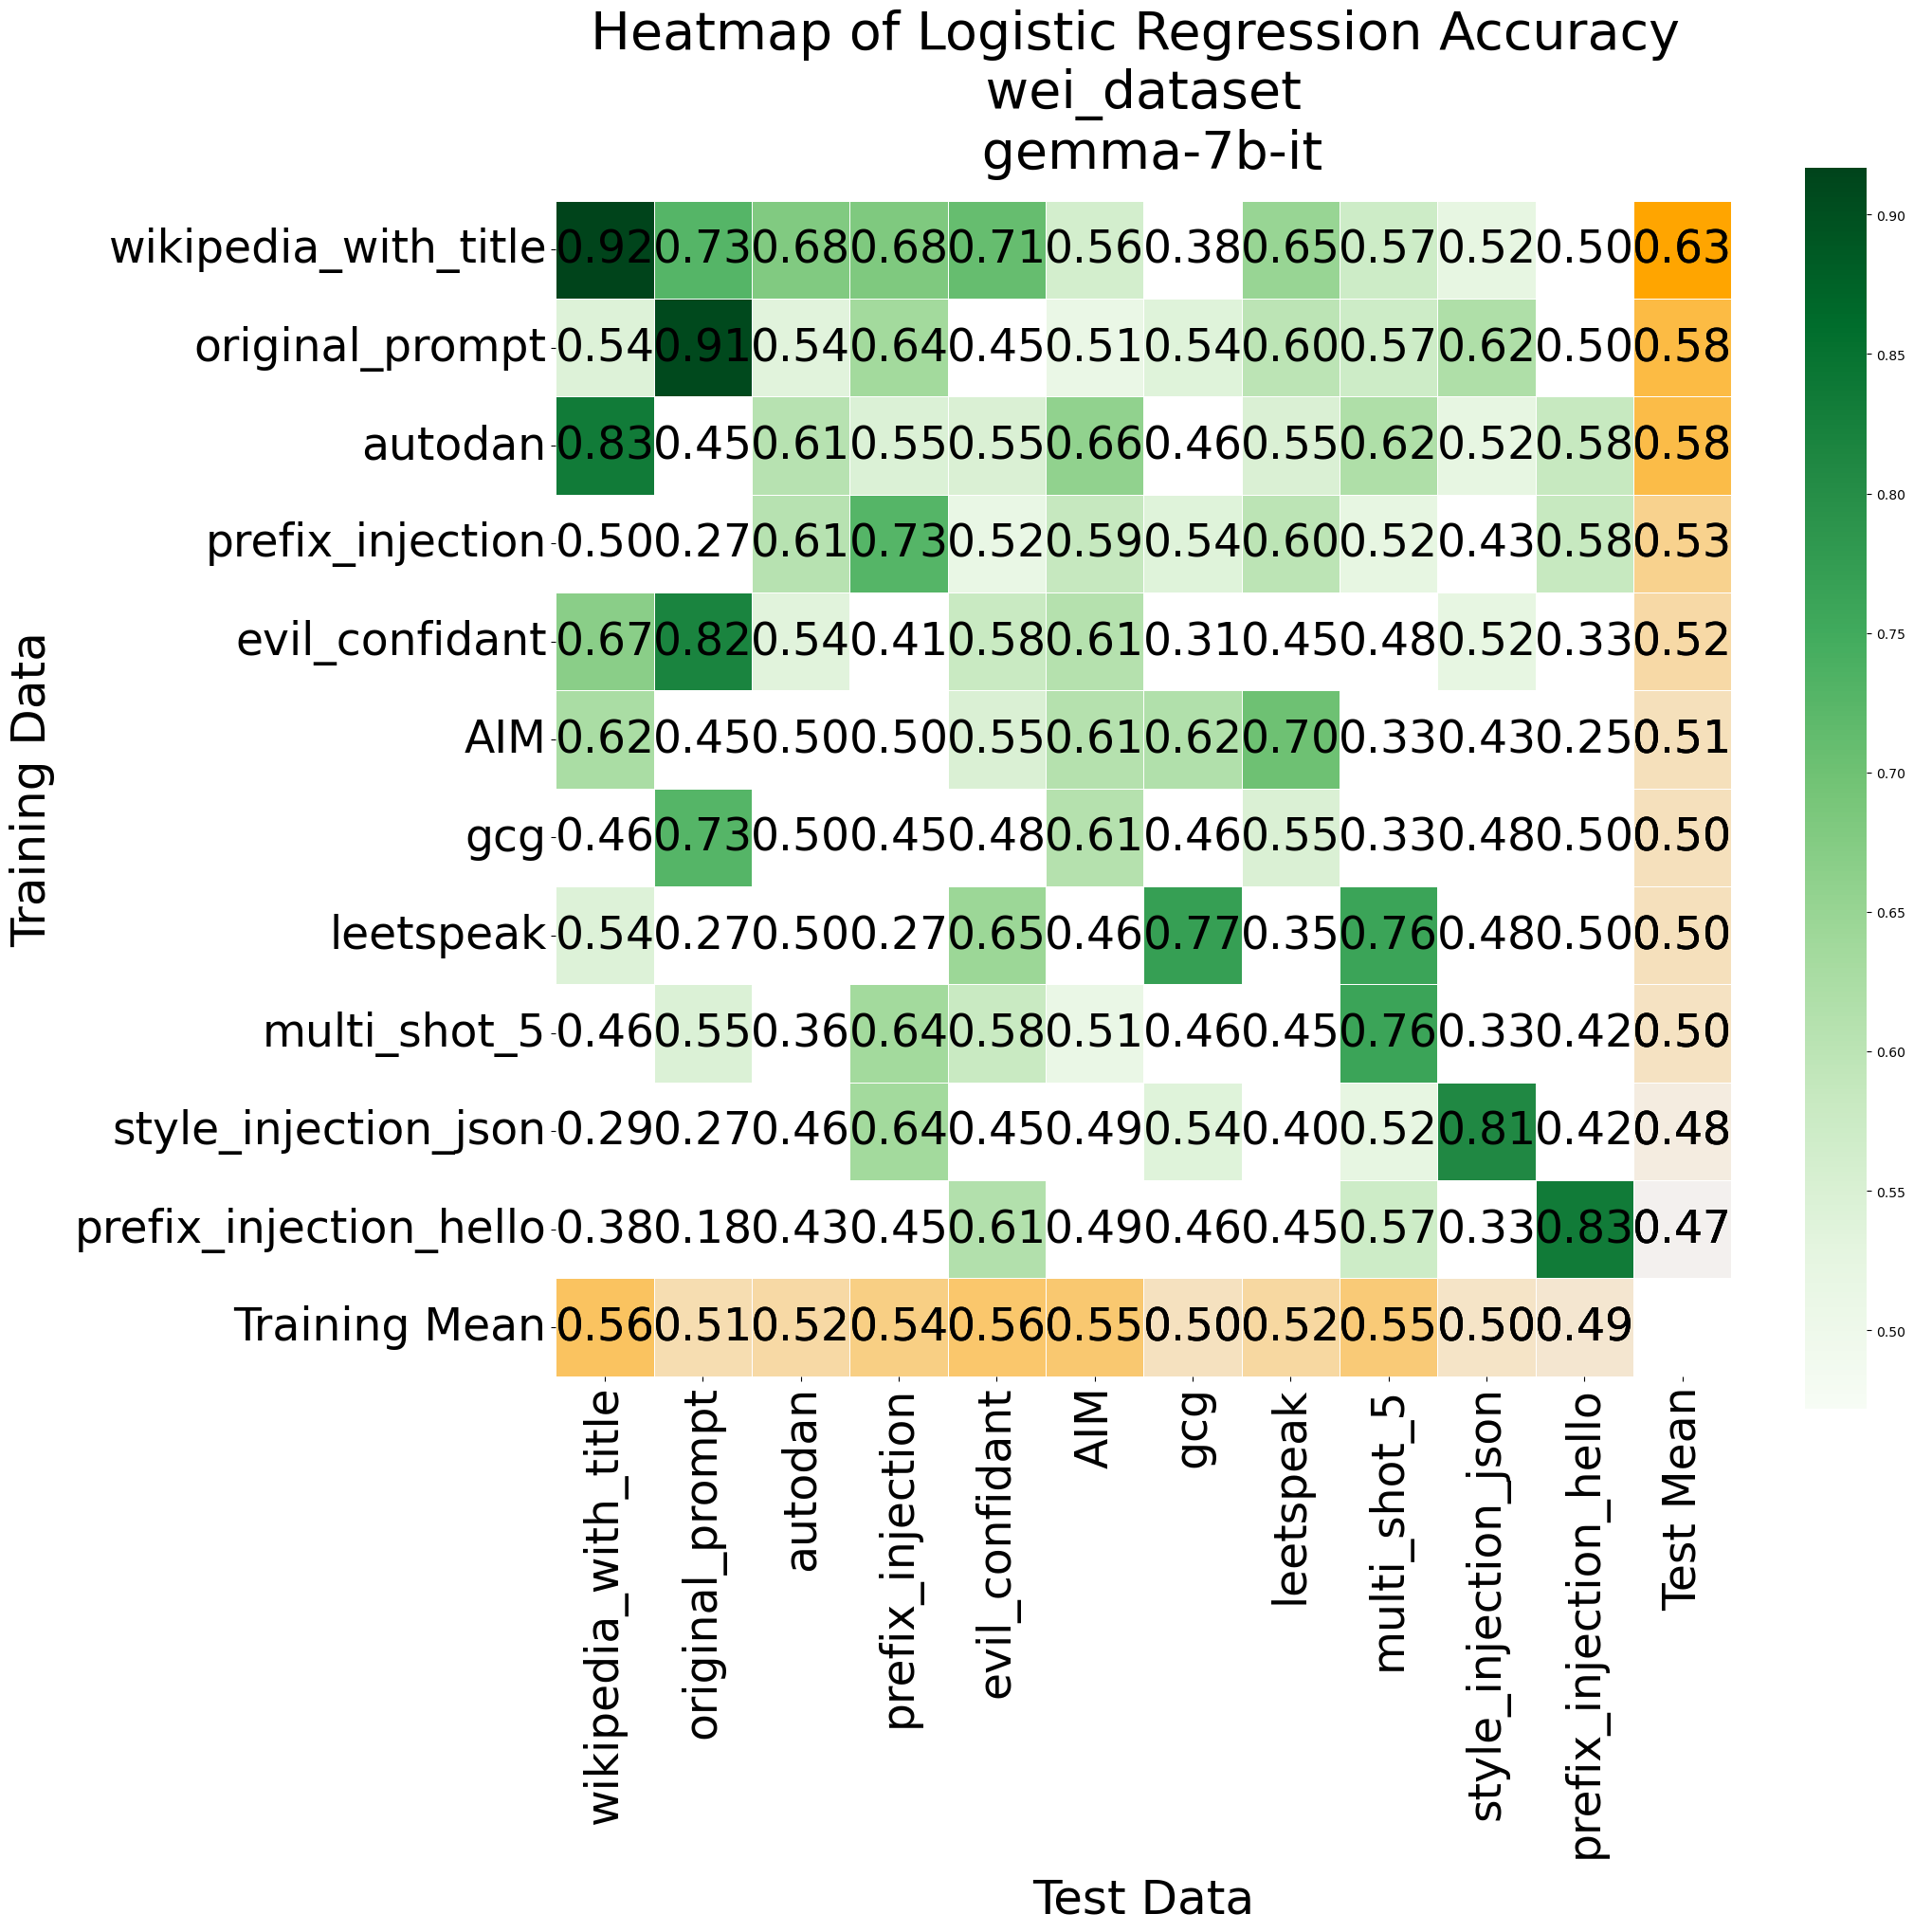

In [15]:
transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "Logistic Regression", savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_linear_jbwise_transfer.pdf")


In [16]:
df[df["jailbreak_prompt_name"] == "AIM"][rating_column].value_counts()

rating
Yes    199
No     101
Name: count, dtype: int64

## Transfer with Holdout

In [17]:
# holdout_df = transfer_with_holdout(df = df, probe_type = "logistic_regression", layer = layer)
# holdout_df
  

In [18]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "logistic_regression", layer = layer)


len df wo holdout:  3000 len df w holdout:  600
Holdout:  original_prompt
before balancing
rating_binary
0    2136
1     864
Name: count, dtype: int64
after balancing
rating_binary
0    864
1    864
Name: count, dtype: int64
eval fn
[array([0.4065765 , 0.11984405, 0.39486167, ..., 0.30909556, 0.05605765,
       0.00200242], dtype=float32), array([ 0.08420281, -0.30149472,  0.2603434 , ..., -0.18655677,
        0.41822302,  0.1203552 ], dtype=float32), array([ 0.13672054,  0.18855835,  0.35064924, ...,  0.04050724,
       -0.26456708, -0.11009741], dtype=float32), array([ 0.16937758, -0.07788026, -0.10344488, ..., -0.12741621,
        0.1079623 ,  0.28711882], dtype=float32), array([ 0.6003678 ,  0.11543246, -0.07880573, ...,  0.19435905,
        0.24761555, -0.00483543], dtype=float32), array([ 0.05337474, -0.02835381,  0.26378903, ...,  0.18085143,
        0.1486769 , -0.04795053], dtype=float32), array([ 0.59159595, -0.15868673,  0.22059548, ..., -0.14674808,
        0.24953367, -0.2

In [19]:
holdout_df

,test accuracy w/o holdout var,test accuracy SE w/o holdout var,test size w/o holdout var,test accuracy w holdout var,test accuracy SE w holdout var,test size w holdout var
original_prompt,0.83237,0.008986,1728,0.856667,0.014306,600
leetspeak,0.833828,0.009071,1684,0.63,0.027875,300
gcg,0.851744,0.008573,1718,0.813333,0.022496,300
autodan,0.869301,0.008318,1642,0.76,0.024658,300
AIM,0.787004,0.011013,1382,0.663333,0.027284,300
prefix_injection_hello,0.805233,0.009549,1720,0.743333,0.025218,300
style_injection_json,0.839286,0.008966,1678,0.19,0.02265,300
evil_confidant,0.828221,0.009348,1628,0.786667,0.023652,300
prefix_injection,0.841791,0.008919,1674,0.266667,0.025531,300
wikipedia_with_title,0.837838,0.009036,1664,0.863333,0.019832,300


In [20]:
print('test accuracy w holdout var' in holdout_df.columns)
print('test accuracy w/o holdout var' in holdout_df.columns)


True
True


In [21]:
mean_transfer = round(holdout_df["test accuracy w holdout var"].mean(),2)

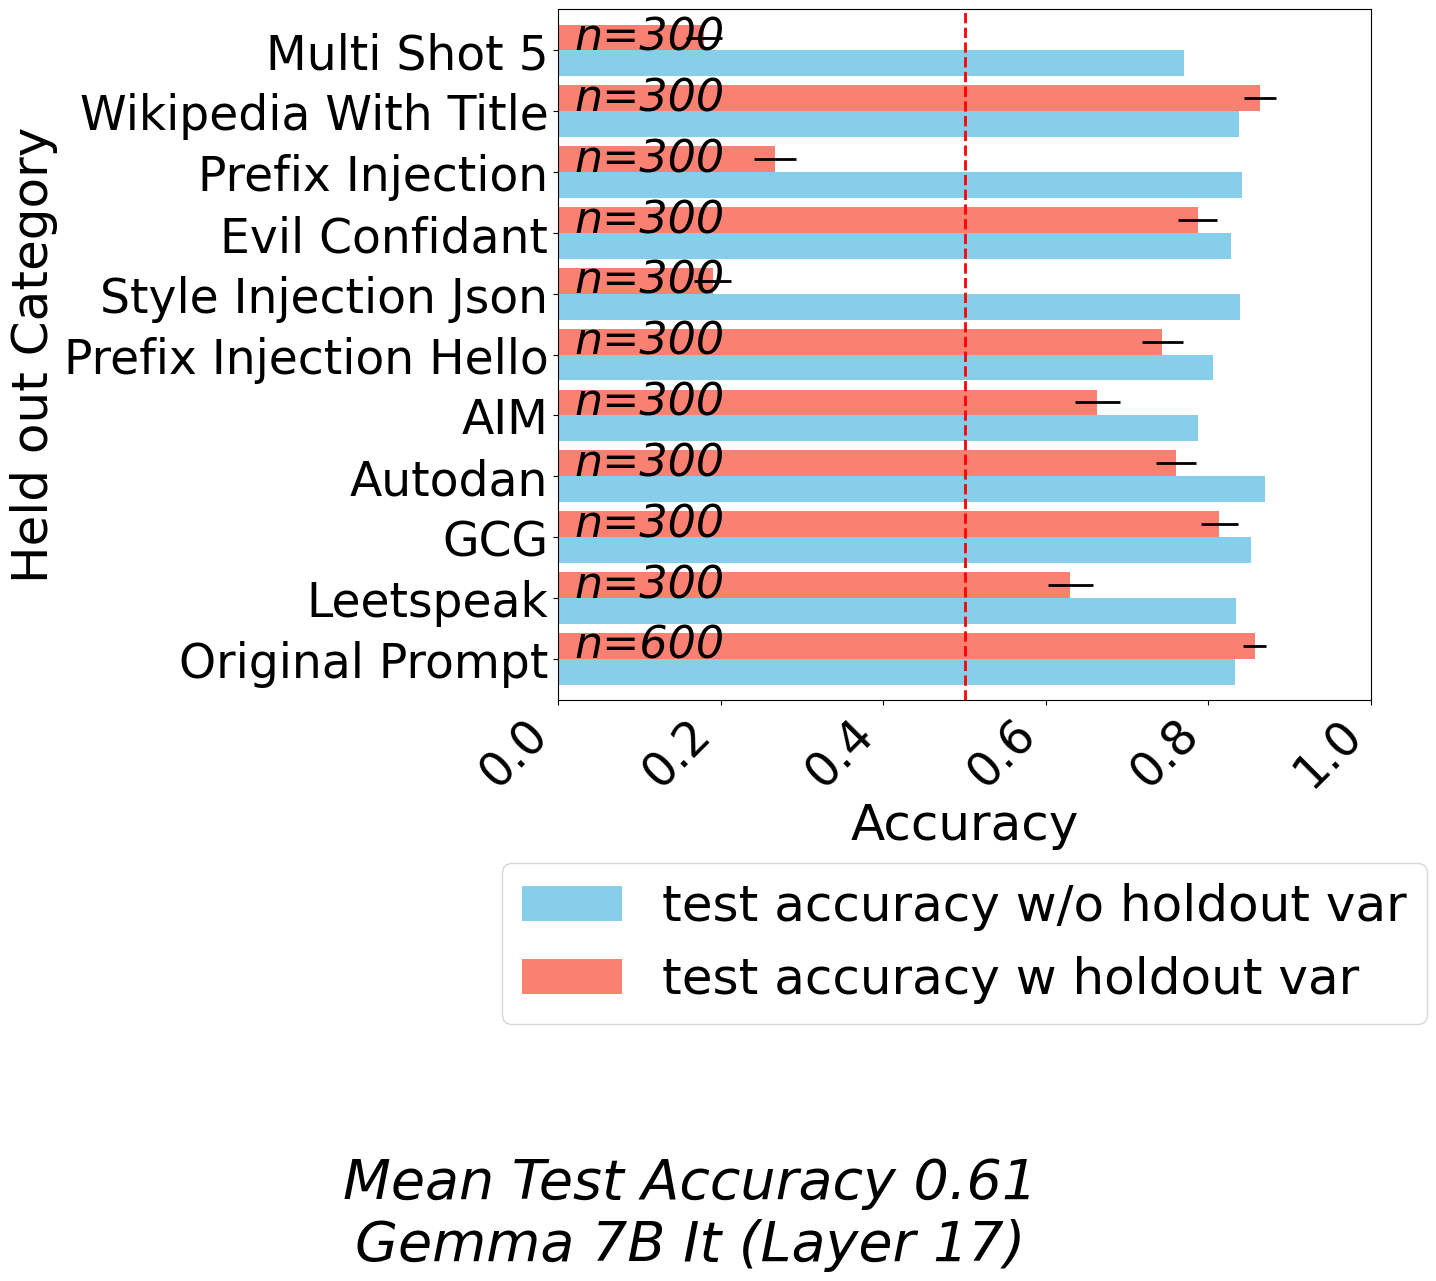

In [22]:
holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "Linear", mean_tranfer_score=mean_transfer, savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_linear_holdout.pdf")

## MLP Probe

In [23]:
from analysis.supervised import *

In [24]:
results_df = probe_transfer(df = df, probe_type = "MLP", layer = layer)


results_df

rating_binary
0    26
1    26
Name: count, dtype: int64
rating_binary
0    48
1    48
Name: count, dtype: int64
rating_binary
0    31
1    31
Name: count, dtype: int64
rating_binary
1    69
0    69
Name: count, dtype: int64
rating_binary
0    101
1    101
Name: count, dtype: int64
rating_binary
1    30
0    30
Name: count, dtype: int64
rating_binary
0    51
1    51
Name: count, dtype: int64
rating_binary
0    76
1    76
Name: count, dtype: int64
rating_binary
1    53
0    53
Name: count, dtype: int64
rating_binary
0    58
1    58
Name: count, dtype: int64
rating_binary
0    51
1    51
Name: count, dtype: int64
PROBE TYPE MLP
eval fn
[array([ 0.58184713, -0.19938898, -0.11786071, ...,  0.00840086,
        0.37790185,  0.03900376], dtype=float32), array([0.2921211 , 0.2795176 , 0.1360946 , ..., 0.00440315, 0.38403282,
       0.07349123], dtype=float32), array([ 1.0612266 , -0.13216683, -0.19689956, ..., -0.0107522 ,
        0.0460152 ,  0.06012607], dtype=float32), array([ 0.27241558, -0

,original_prompt,leetspeak,gcg,autodan,AIM,prefix_injection_hello,style_injection_json,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
original_prompt,0.909091,0.6,0.615385,0.392857,0.585366,0.583333,0.52381,0.451613,0.454545,0.708333,0.666667
leetspeak,0.727273,0.4,0.538462,0.571429,0.585366,0.5,0.619048,0.548387,0.727273,0.458333,0.571429
gcg,0.545455,0.45,0.384615,0.571429,0.609756,0.666667,0.333333,0.387097,0.409091,0.583333,0.428571
autodan,0.909091,0.65,0.538462,0.571429,0.536585,0.5,0.47619,0.741935,0.5,0.541667,0.571429
AIM,0.454545,0.5,0.538462,0.321429,0.658537,0.75,0.47619,0.516129,0.590909,0.583333,0.571429
prefix_injection_hello,0.636364,0.6,0.615385,0.607143,0.512195,0.416667,0.428571,0.419355,0.5,0.75,0.52381
style_injection_json,0.454545,0.6,0.461538,0.535714,0.585366,0.916667,0.619048,0.548387,0.636364,0.5,0.333333
evil_confidant,0.727273,0.7,0.846154,0.464286,0.487805,0.333333,0.571429,0.677419,0.545455,0.75,0.52381
prefix_injection,0.454545,0.4,0.538462,0.428571,0.682927,0.5,0.333333,0.580645,0.363636,0.666667,0.571429
wikipedia_with_title,0.727273,0.65,0.461538,0.535714,0.463415,0.416667,0.619048,0.612903,0.681818,0.541667,0.52381


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:632: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


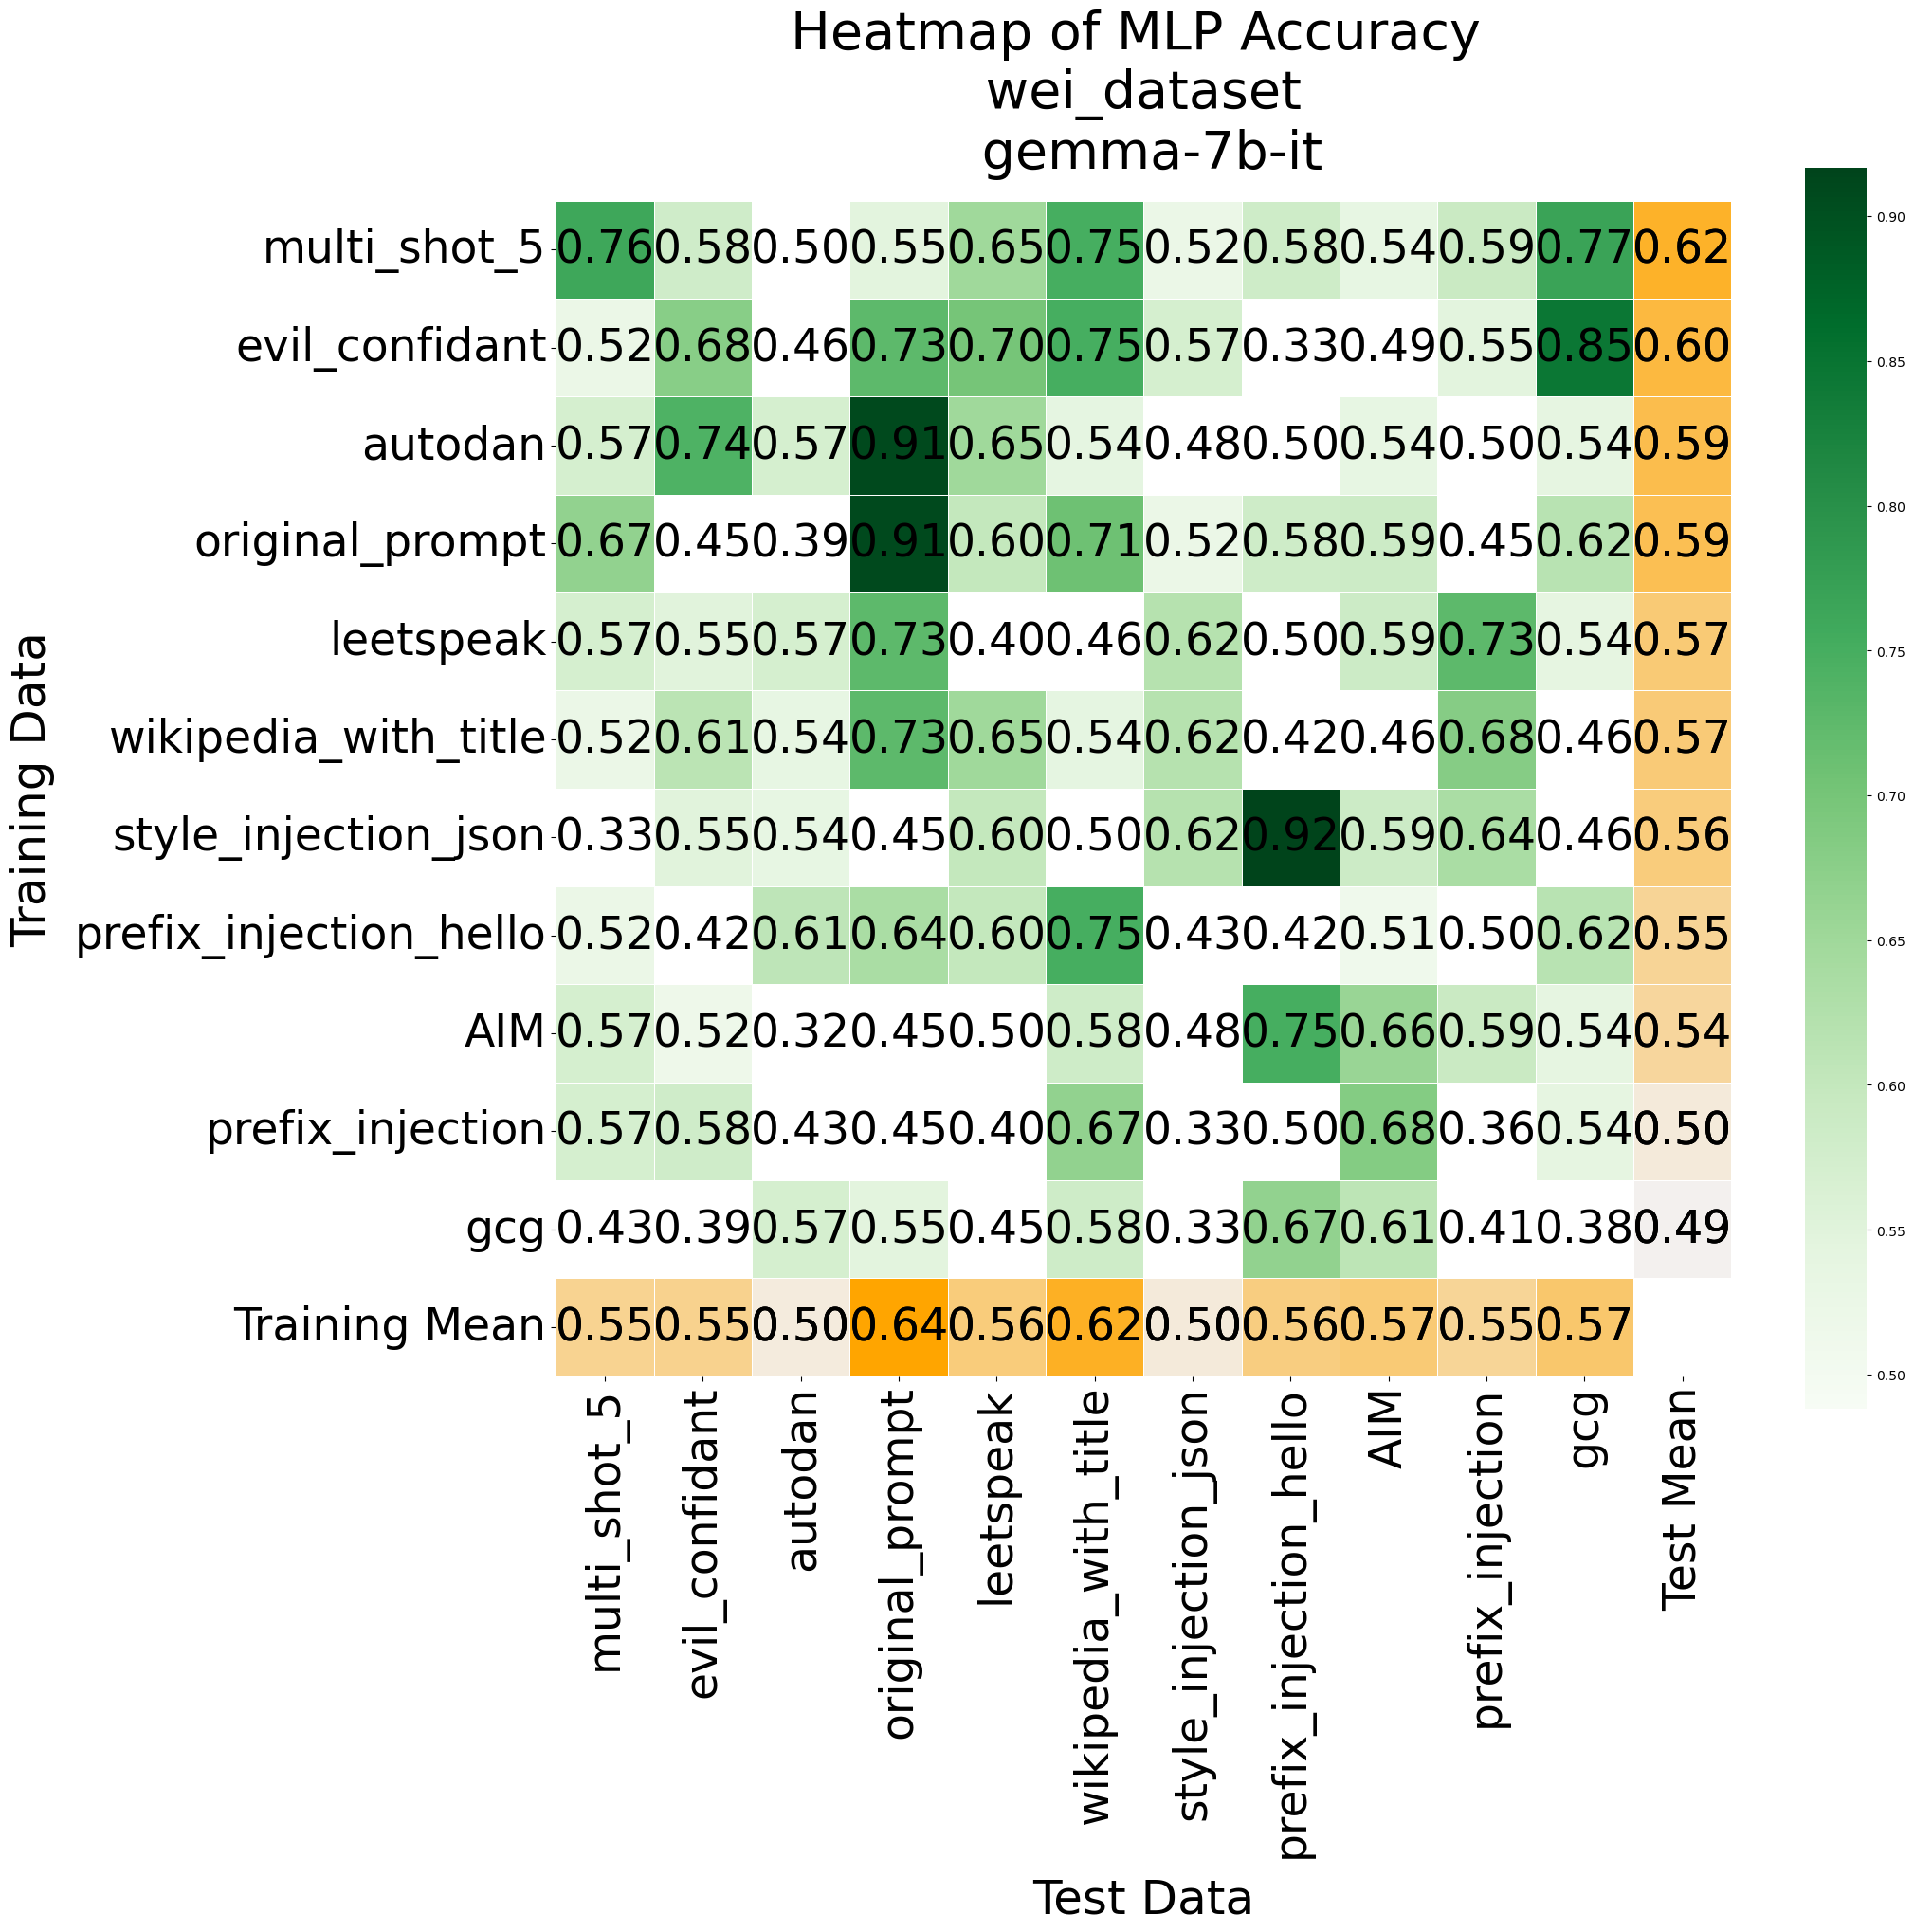

In [25]:
plot = transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "MLP", savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_MLP_jbwise_transfer.pdf")

In [26]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "MLP", layer = layer)


len df wo holdout:  3000 len df w holdout:  600
Holdout:  original_prompt
before balancing
rating_binary
0    2136
1     864
Name: count, dtype: int64
after balancing
rating_binary
1    864
0    864
Name: count, dtype: int64
eval fn
[array([0.4065765 , 0.11984405, 0.39486167, ..., 0.30909556, 0.05605765,
       0.00200242], dtype=float32), array([ 0.08420281, -0.30149472,  0.2603434 , ..., -0.18655677,
        0.41822302,  0.1203552 ], dtype=float32), array([ 0.13672054,  0.18855835,  0.35064924, ...,  0.04050724,
       -0.26456708, -0.11009741], dtype=float32), array([ 0.16937758, -0.07788026, -0.10344488, ..., -0.12741621,
        0.1079623 ,  0.28711882], dtype=float32), array([ 0.6003678 ,  0.11543246, -0.07880573, ...,  0.19435905,
        0.24761555, -0.00483543], dtype=float32), array([ 0.05337474, -0.02835381,  0.26378903, ...,  0.18085143,
        0.1486769 , -0.04795053], dtype=float32), array([ 0.59159595, -0.15868673,  0.22059548, ..., -0.14674808,
        0.24953367, -0.2

eval fn
[array([ 0.23916042,  0.26110697,  0.10546674, ...,  0.09593952,
       -0.07965368, -0.10037671], dtype=float32), array([ 0.28751233,  0.13168475,  0.08209261, ...,  0.08839841,
       -0.12953044, -0.01063423], dtype=float32), array([ 0.24187577,  0.25596917,  0.10258085, ...,  0.14066719,
       -0.21027641, -0.0534436 ], dtype=float32), array([ 0.25280035,  0.18540637,  0.0764716 , ...,  0.21132922,
       -0.114251  ,  0.01614084], dtype=float32), array([ 0.2253649 ,  0.1638419 ,  0.07320514, ...,  0.09132918,
       -0.16040316, -0.01071429], dtype=float32), array([ 0.22524744,  0.2199184 ,  0.12711176, ...,  0.09702106,
       -0.12310766, -0.0100426 ], dtype=float32), array([ 0.29945394,  0.20904773,  0.03717613, ...,  0.1063147 ,
       -0.16878615, -0.0192737 ], dtype=float32), array([ 0.20253795,  0.2562226 ,  0.09920502, ...,  0.09809005,
       -0.19194953, -0.01557291], dtype=float32), array([ 0.28558862,  0.16173208,  0.1481101 , ...,  0.11795022,
       -0.13458

In [27]:
holdout_df

,test accuracy w/o holdout var,test accuracy SE w/o holdout var,test size w/o holdout var,test accuracy w holdout var,test accuracy SE w holdout var,test size w holdout var
original_prompt,0.783237,0.009912,1728,0.836667,0.015092,600
leetspeak,0.738872,0.010704,1684,0.256667,0.025218,300
gcg,0.72093,0.010822,1718,0.446667,0.028703,300
autodan,0.75076,0.010675,1642,0.74,0.025325,300
AIM,0.732852,0.011902,1382,0.673333,0.027077,300
prefix_injection_hello,0.738372,0.010598,1720,0.1,0.017321,300
style_injection_json,0.761905,0.010398,1678,0.203333,0.023237,300
evil_confidant,0.837423,0.009145,1628,0.766667,0.024419,300
prefix_injection,0.826866,0.009248,1674,0.85,0.020616,300
wikipedia_with_title,0.786787,0.010041,1664,0.72,0.025923,300


In [28]:
# get mean of holdout_df["Test Set (Holdout)"]
mean_transfer = round(holdout_df["test accuracy w holdout var"].mean(),2)

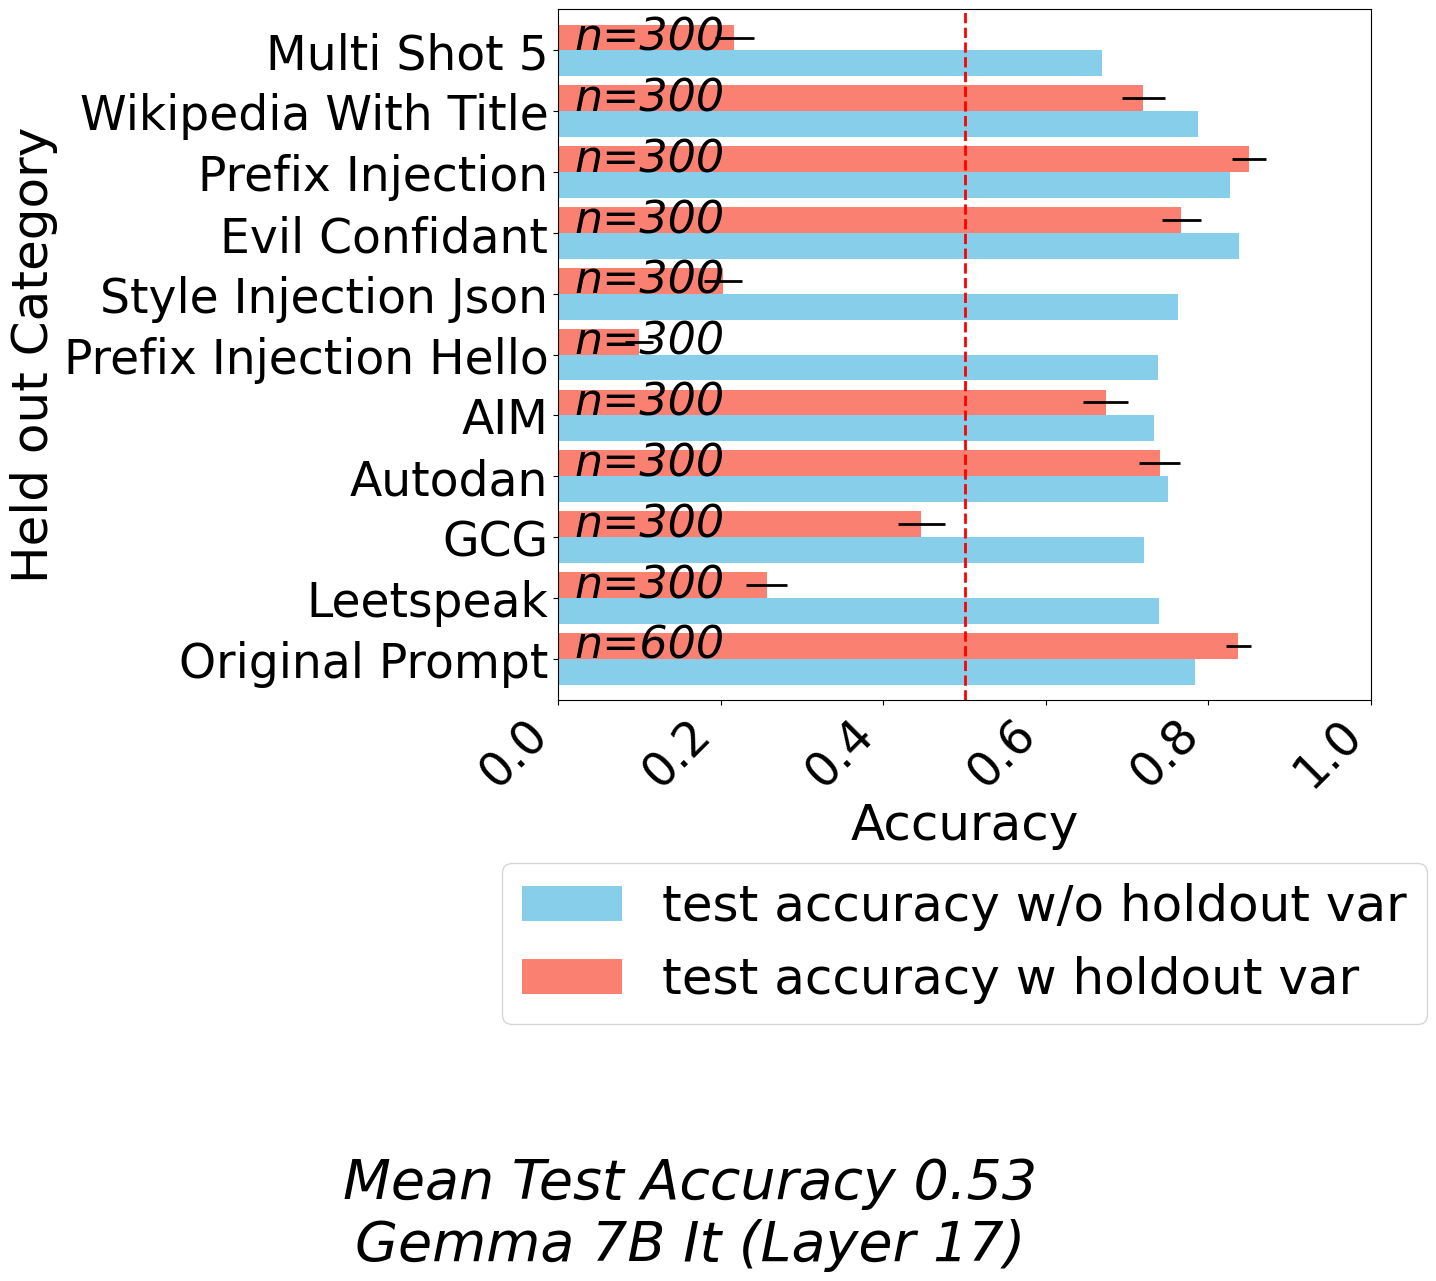

In [29]:
plot = holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "MLP", mean_tranfer_score= mean_transfer, savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_MLP_holdout.pdf")

## 